#### Проект по расчету Retention Rate.

##### Один из главных критериев качества — как долго клиент остаётся с компанией. Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулись, то есть воспользовались продуктом или услугой, в последующие периоды. 

##### Далее мы посмотрим, как удерживалась аудитория на сайте stackoverflow с июля по декабрь 2008 года. Также визуализируем эти данные в тепловой карте библиотеки seaborn. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [30]:
# напишите запрос
query = '''
 
WITH events as -- пользователь и даты его постов усеченные до месяца
    (SELECT user_id, DATE_TRUNC('month', creation_date)::date event_time
    FROM stackoverflow.posts
    GROUP BY 1,2),

     profile as --пользователь, первый пост и количество пользователей с первым постом в эту дату.
    (SELECT user_id, first_post, COUNT(*) OVER (PARTITION BY first_post) AS cohort_users_cnt
 FROM (SELECT user_id, MIN(DATE_TRUNC('month', creation_date)::date) first_post
    FROM stackoverflow.posts
    GROUP BY 1
    ORDER BY 2) as ab),
    
    retention as
    (SELECT 
    first_post AS cohort_dt, -- дата первого поста
    event_time, -- дата события 
    COUNT(p.user_id) AS users_cnt, --количетво юзеров, у которых были события с таким же первым постом и событием
    cohort_users_cnt,
    ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p 
JOIN events e ON p.user_id = e.user_id
GROUP BY 1,
         2,
         4)
SELECT cohort_dt, event_time, retention_rate, ROUND((event_time::date - cohort_dt::date)/30) as lifetime
FROM retention;
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df
# выполните запрос

,cohort_dt,event_time,retention_rate,lifetime
0,2008-07-01,2008-07-01,100.00,0.0
1,2008-07-01,2008-08-01,66.67,1.0
2,2008-07-01,2008-09-01,33.33,2.0
3,2008-07-01,2008-10-01,66.67,3.0
4,2008-07-01,2008-11-01,33.33,4.0
5,2008-07-01,2008-12-01,66.67,5.0
6,2008-08-01,2008-08-01,100.00,0.0
7,2008-08-01,2008-09-01,73.04,1.0
8,2008-08-01,2008-10-01,59.27,2.0
9,2008-08-01,2008-11-01,48.81,3.0


In [32]:
t = sample_df

Переворачиваем датафрейм таким образом, чтобы он приобрел правильный вид "косынки" и его правильно прорисовала библиотека seaborn

In [35]:
ret = t.pivot_table(index='cohort_dt',columns='lifetime',values='retention_rate',aggfunc='min')

In [36]:
ret

lifetime,0.0,1.0,2.0,3.0,4.0,5.0
cohort_dt,,,,,,
2008-07-01,100.0,66.67,33.33,66.67,33.33,66.67
2008-08-01,100.0,73.04,59.27,48.81,41.56,NaN
2008-09-01,100.0,53.82,38.63,32.56,NaN,NaN
2008-10-01,100.0,45.19,33.65,NaN,NaN,NaN
2008-11-01,100.0,40.36,NaN,NaN,NaN,NaN
2008-12-01,100.0,NaN,NaN,NaN,NaN,NaN


In [39]:

import seaborn as sns


<AxesSubplot:xlabel='lifetime', ylabel='cohort_dt'>

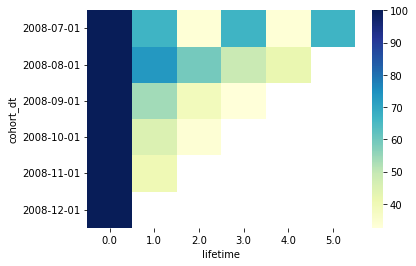

In [41]:
sns.heatmap(ret, cmap="YlGnBu")

По этой тепловой карте мы видим, что на начальных месяцах удержание аудитории значительно лучше, чем к концу выбранного периода. Т.к. на этот временной промежуток приходится старт проекта stackoverflow, то мы можем предположить, что начальные высокие показатели удержания связаны с повышенным интересом пользователей к новому проекту. 